In [3]:
#install dependencies
!pip install deepcell==0.10.1 torch torchvision transformers

     |████████████████████████████████| 139 kB 19.8 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing wheel metadata (pyproject.toml) ... done
     |████████████████████████████████| 887.5 MB 17 kB/s              
     |████████████████████████████████| 24.2 MB 69.1 MB/s            
     |████████████████████████████████| 7.2 MB 61.8 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 460.3 MB 16 kB/s              
     |████████████████████████████████| 679 kB 63.4 MB/s            
     |████████████████████████████████| 123 kB 71.4 MB/s            
     |████████████████████████████████| 40 kB 6.6 MB/s             
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing wheel metadata (pyproject.toml) ... done
  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
     |████████████████████████████████| 49.1 MB

In [46]:
import os
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib import patches
from skimage.measure import regionprops
from skimage.exposure import rescale_intensity
from transformers import SamModel, SamProcessor, SamVisionConfig, SamConfig
from PIL import Image
from deepcell_toolbox.metrics import PixelMetrics

In [5]:
#load TissueNet
tn = np.load('/sbgenomics/project-files/tissuenet_v1.1_test.npz')

In [18]:
#load Mesmer masks
mesmer = np.load('/sbgenomics/project-files/mesmer_tissuenet_nuclear_masks.npz')

In [43]:
# get sample image and mask
im = rescale_intensity(tn['X'][10],out_range='uint8')[:,:,0] #nuclei
mask = tn['y'][10]
mesmer_mask = mesmer['y'][10]

# prepare image + promps
image_in = Image.fromarray(np.stack([im, im, im],axis=2))
props_in = regionprops(mesmer_mask)

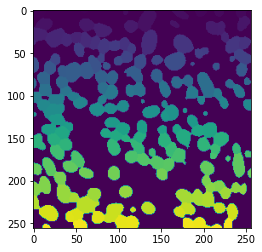

In [86]:
plt.imshow(mesmer_mask)

In [26]:
# load MedSAM
device = 0 if torch.cuda.is_available() else "cpu"

processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")
model = SamModel.from_pretrained("wanglab/medsam-vit-base").to(device)

In [47]:
out_masks = []
for p in tqdm(props_in):
    bbox = [p.bbox[0],p.bbox[1],p.bbox[3],p.bbox[4]]
    inputs = processor(image_in, input_boxes=[[bbox]], return_tensors="pt").to(device)
    with torch.no_grad():
          outputs = model(**inputs, multimask_output=False)
        
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    out_masks.append(medsam_seg)

100%|██████████| 183/183 [00:32<00:00,  5.62it/s]


In [67]:
# combine individual masks
medSAM = np.zeros(out_masks[0].shape)
for i,m in enumerate(out_masks):
    m[m>0] = i + 1
    out_masks[i] = m
for i,m in enumerate(out_masks):
    cell_id = i + 1
    medSAM[(medSAM == 0) & (m == cell_id)] = cell_id

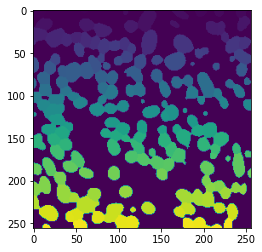

In [62]:
plt.imshow(mesmer_mask)

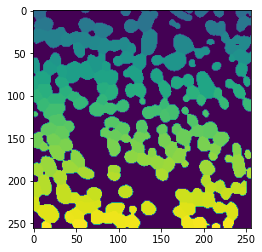

In [63]:
plt.imshow(mask[:,:,1])

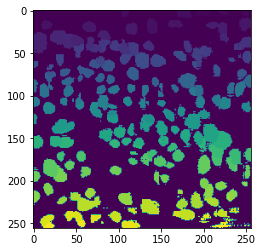

In [77]:
# have to rotate + flip?
plt.imshow(np.flip(np.rot90(medSAM,k=3),axis=1))
plt.show()

In [90]:
medSAM = np.expand_dims(np.flip(np.rot90(medSAM,k=3),axis=1), 0)
test_mask = np.expand_dims(mask[:,:,1], 0)

In [93]:
mesmer_mask.shape

(256, 256, 1)

In [95]:
metrics = PixelMetrics(np.expand_dims(test_mask, 3), np.expand_dims(mesmer_mask, 0))
metrics.f1

0.9169490202201577

In [96]:
metrics = PixelMetrics(np.expand_dims(test_mask, 3), np.expand_dims(medSAM, 3))
metrics.f1

0.6265973730110703

In [98]:
test_mask.dtype

dtype('int32')

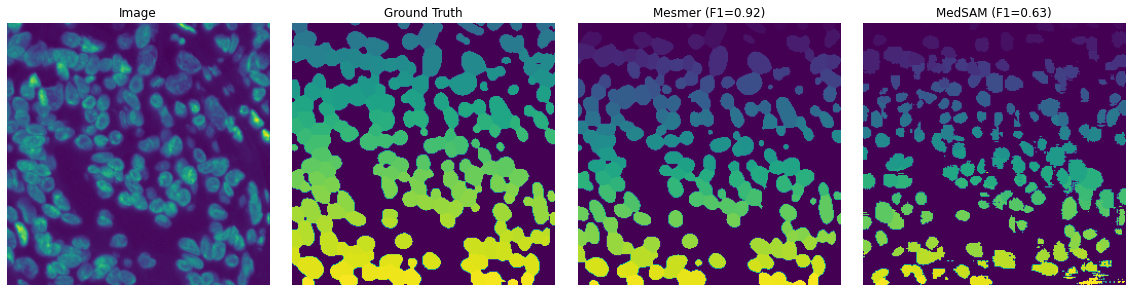

In [101]:
fig, ax = plt.subplots(1,4,figsize=(16,4))
ax[0].imshow(im)
ax[1].imshow(test_mask.squeeze())
ax[2].imshow(mesmer_mask.squeeze())
ax[3].imshow(new.squeeze())
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
ax[0].set_title('Image')
ax[1].set_title('Ground Truth')
ax[2].set_title('Mesmer (F1=0.92)')
ax[3].set_title('MedSAM (F1=0.63)')
plt.tight_layout()
plt.show()